## Metrics

汇总常见2分类的指标，例如: AUC，ROC曲线，ACC, 敏感性， 特异性，精确度，召回率，PPV, NPV, F1

具体的介绍，可以参考一下：https://blog.csdn.net/sunflower_sara/article/details/81214897

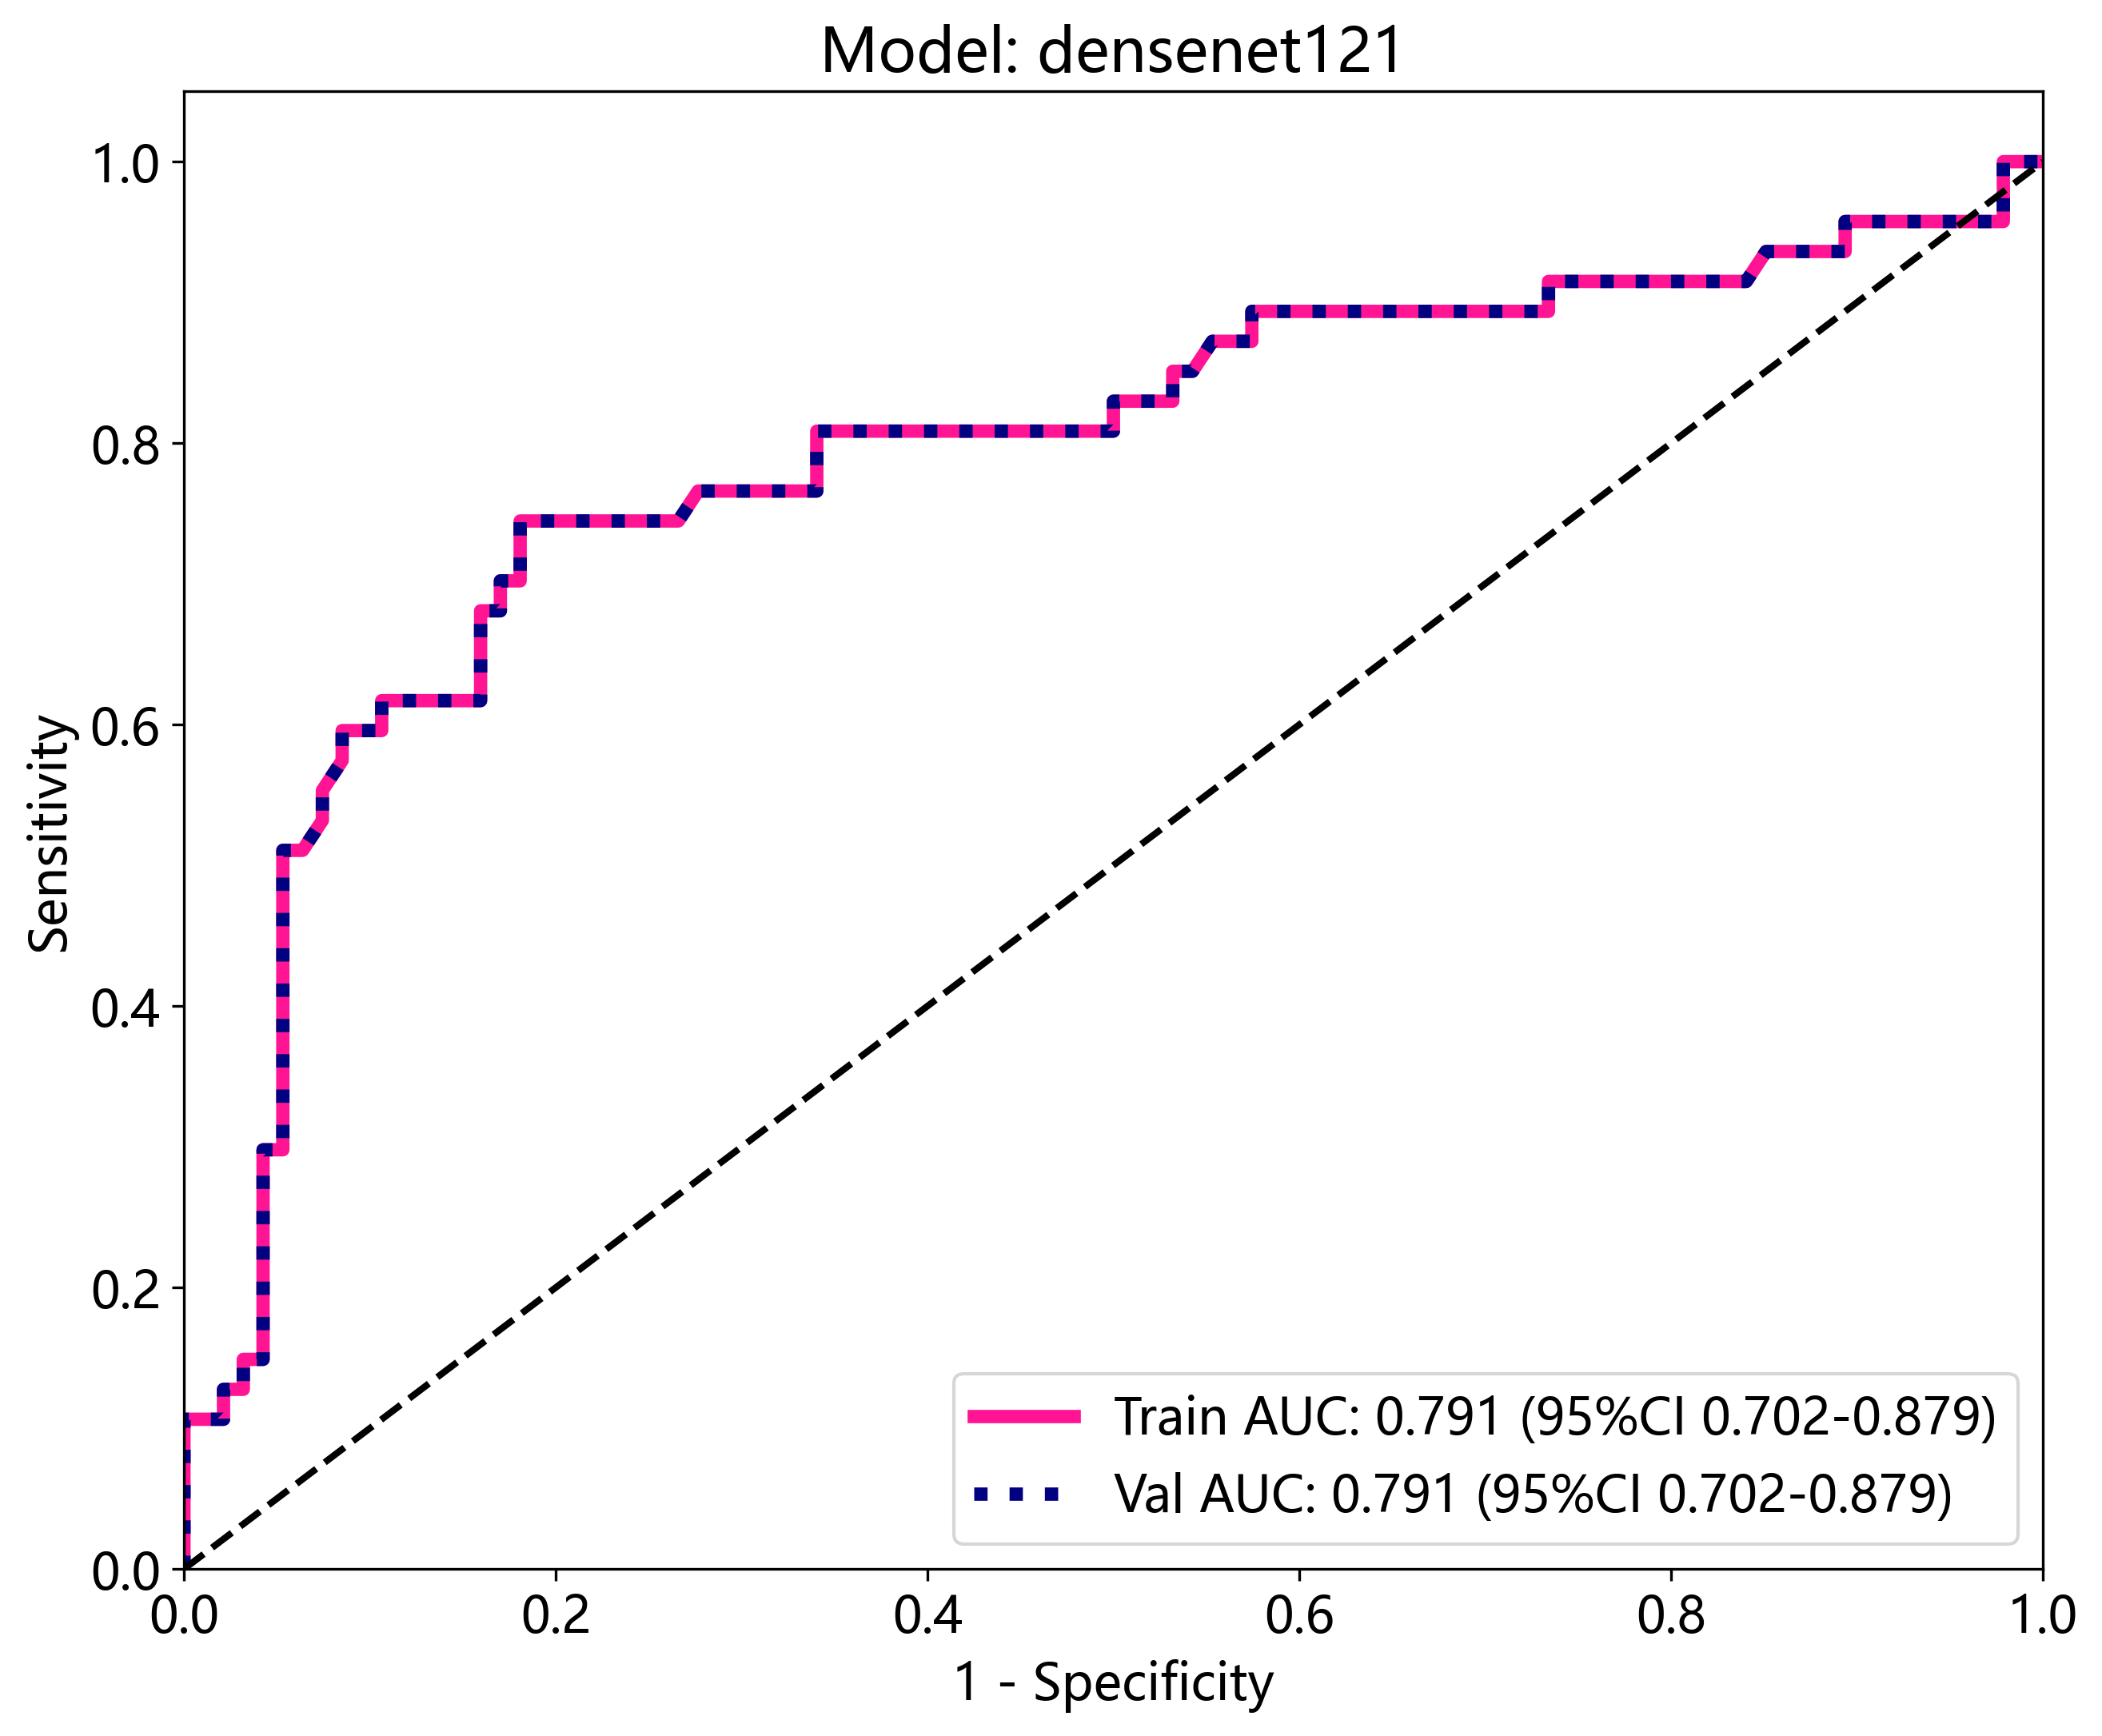

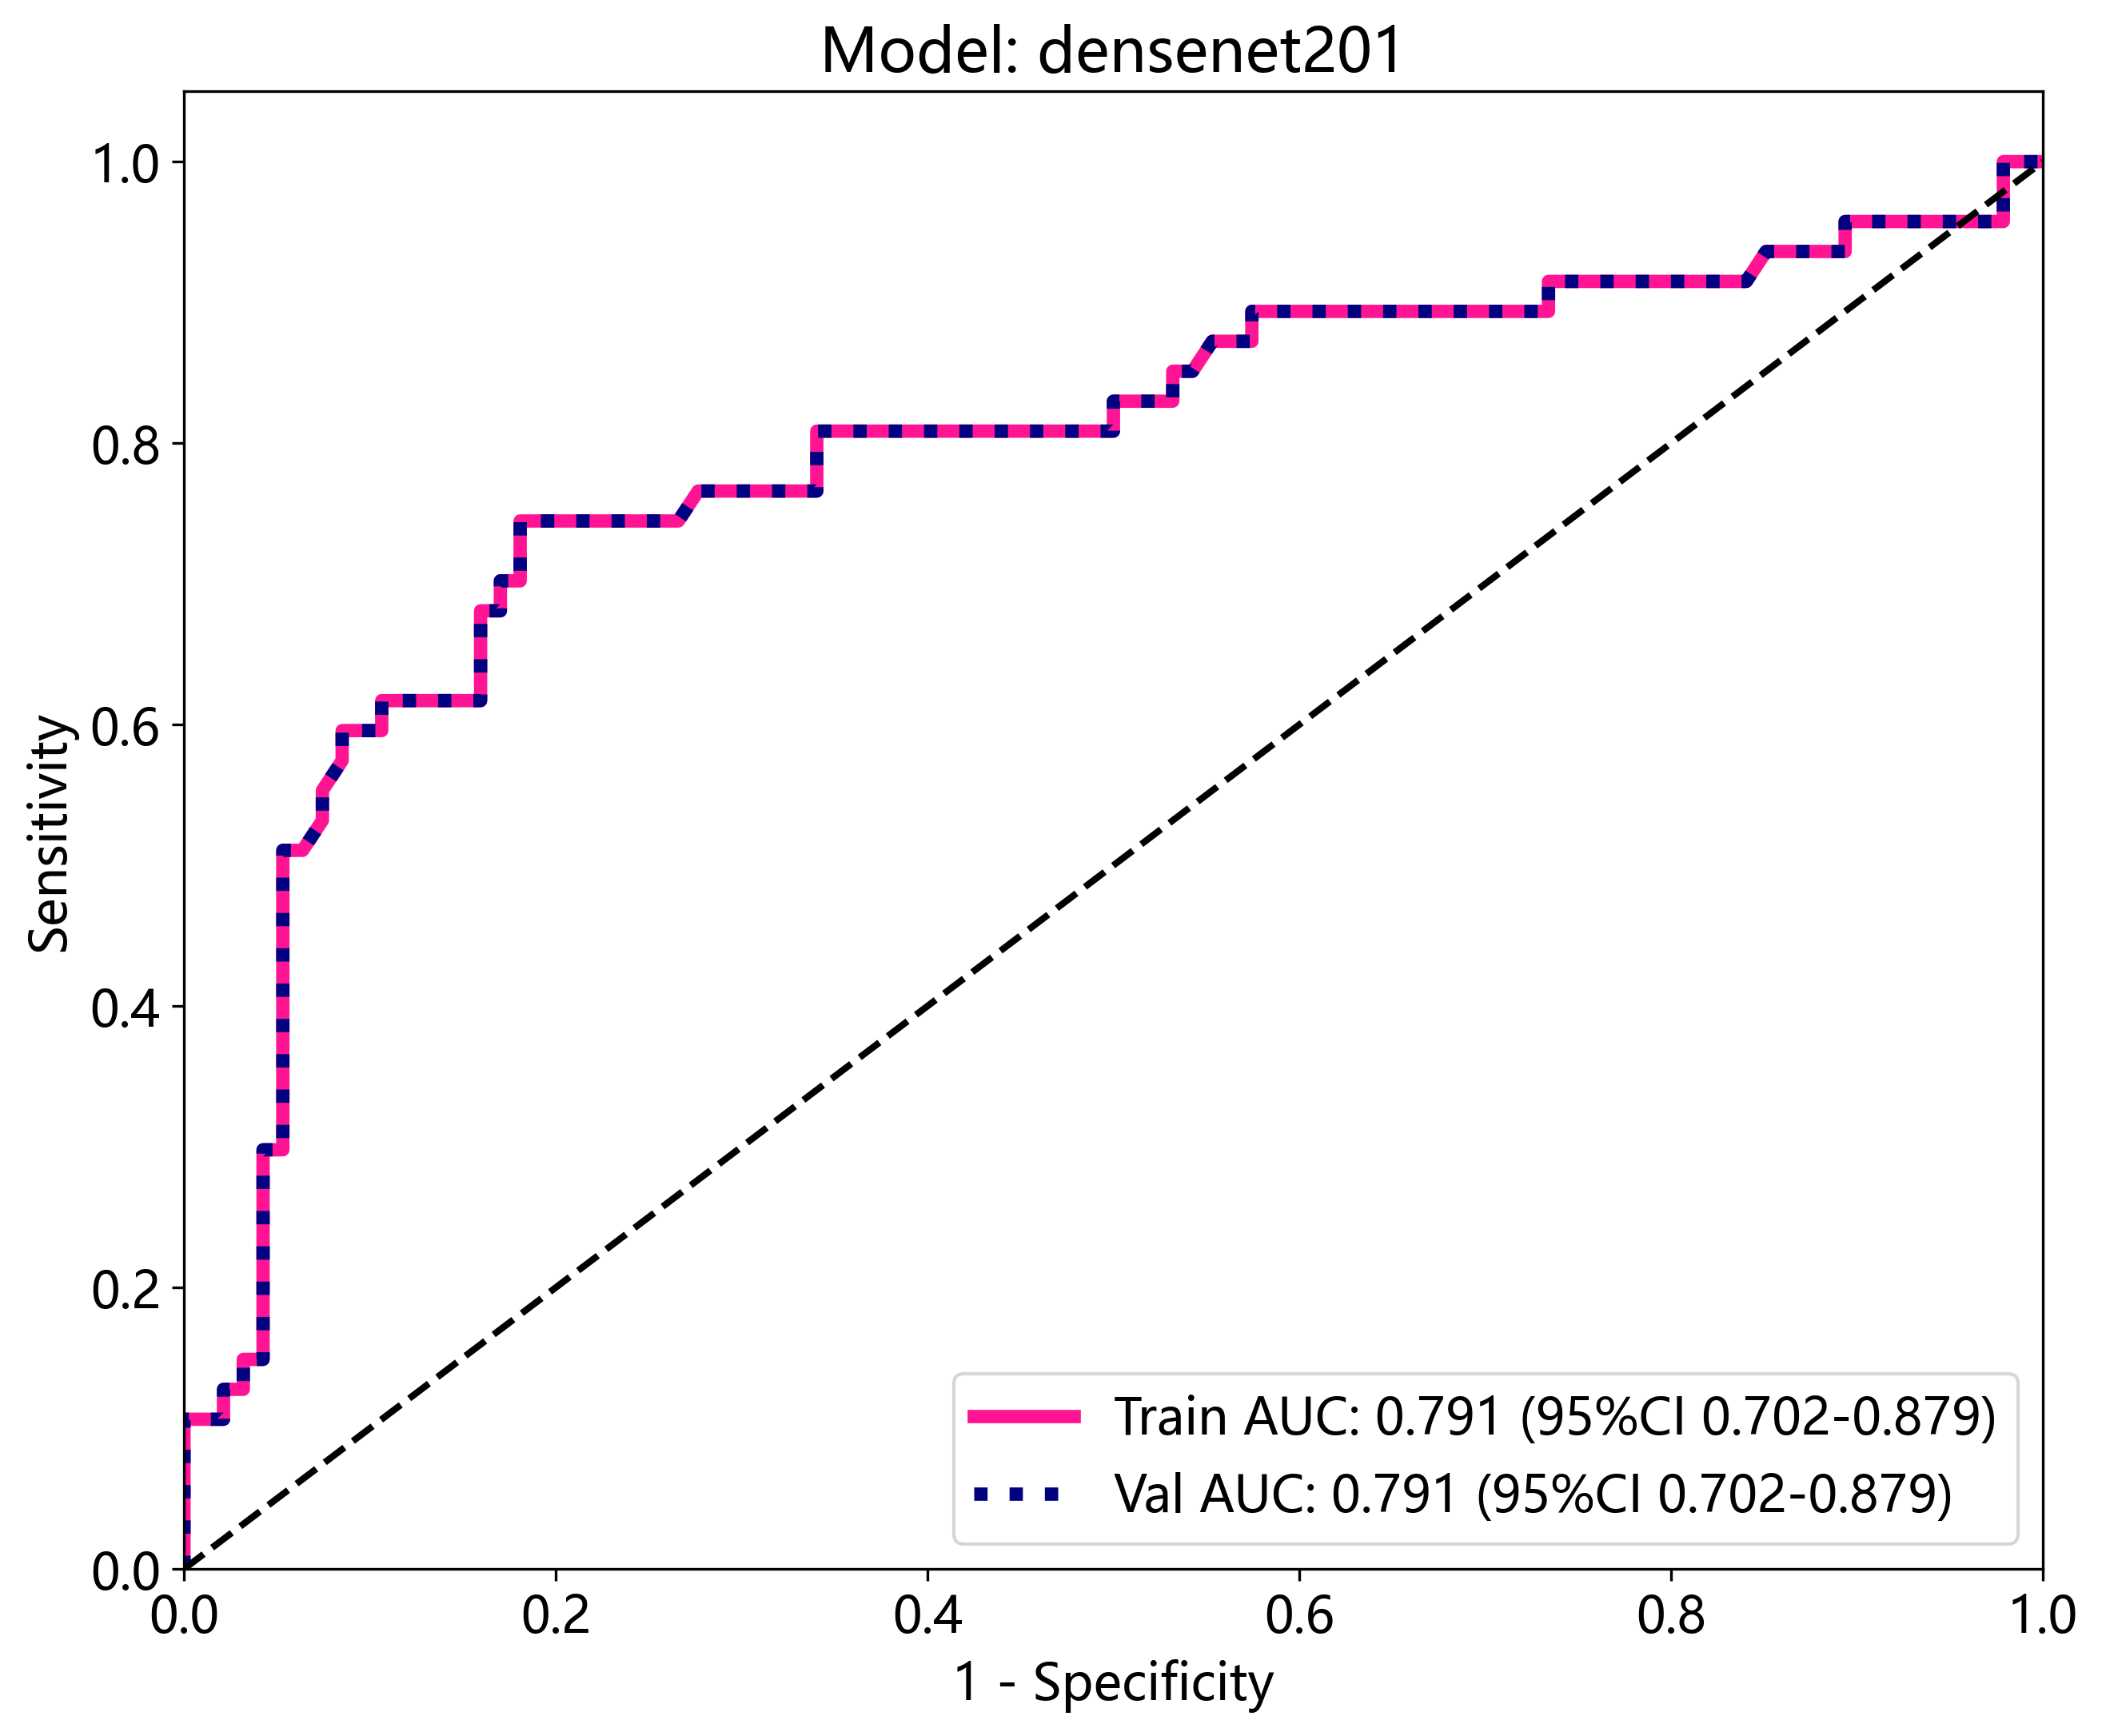

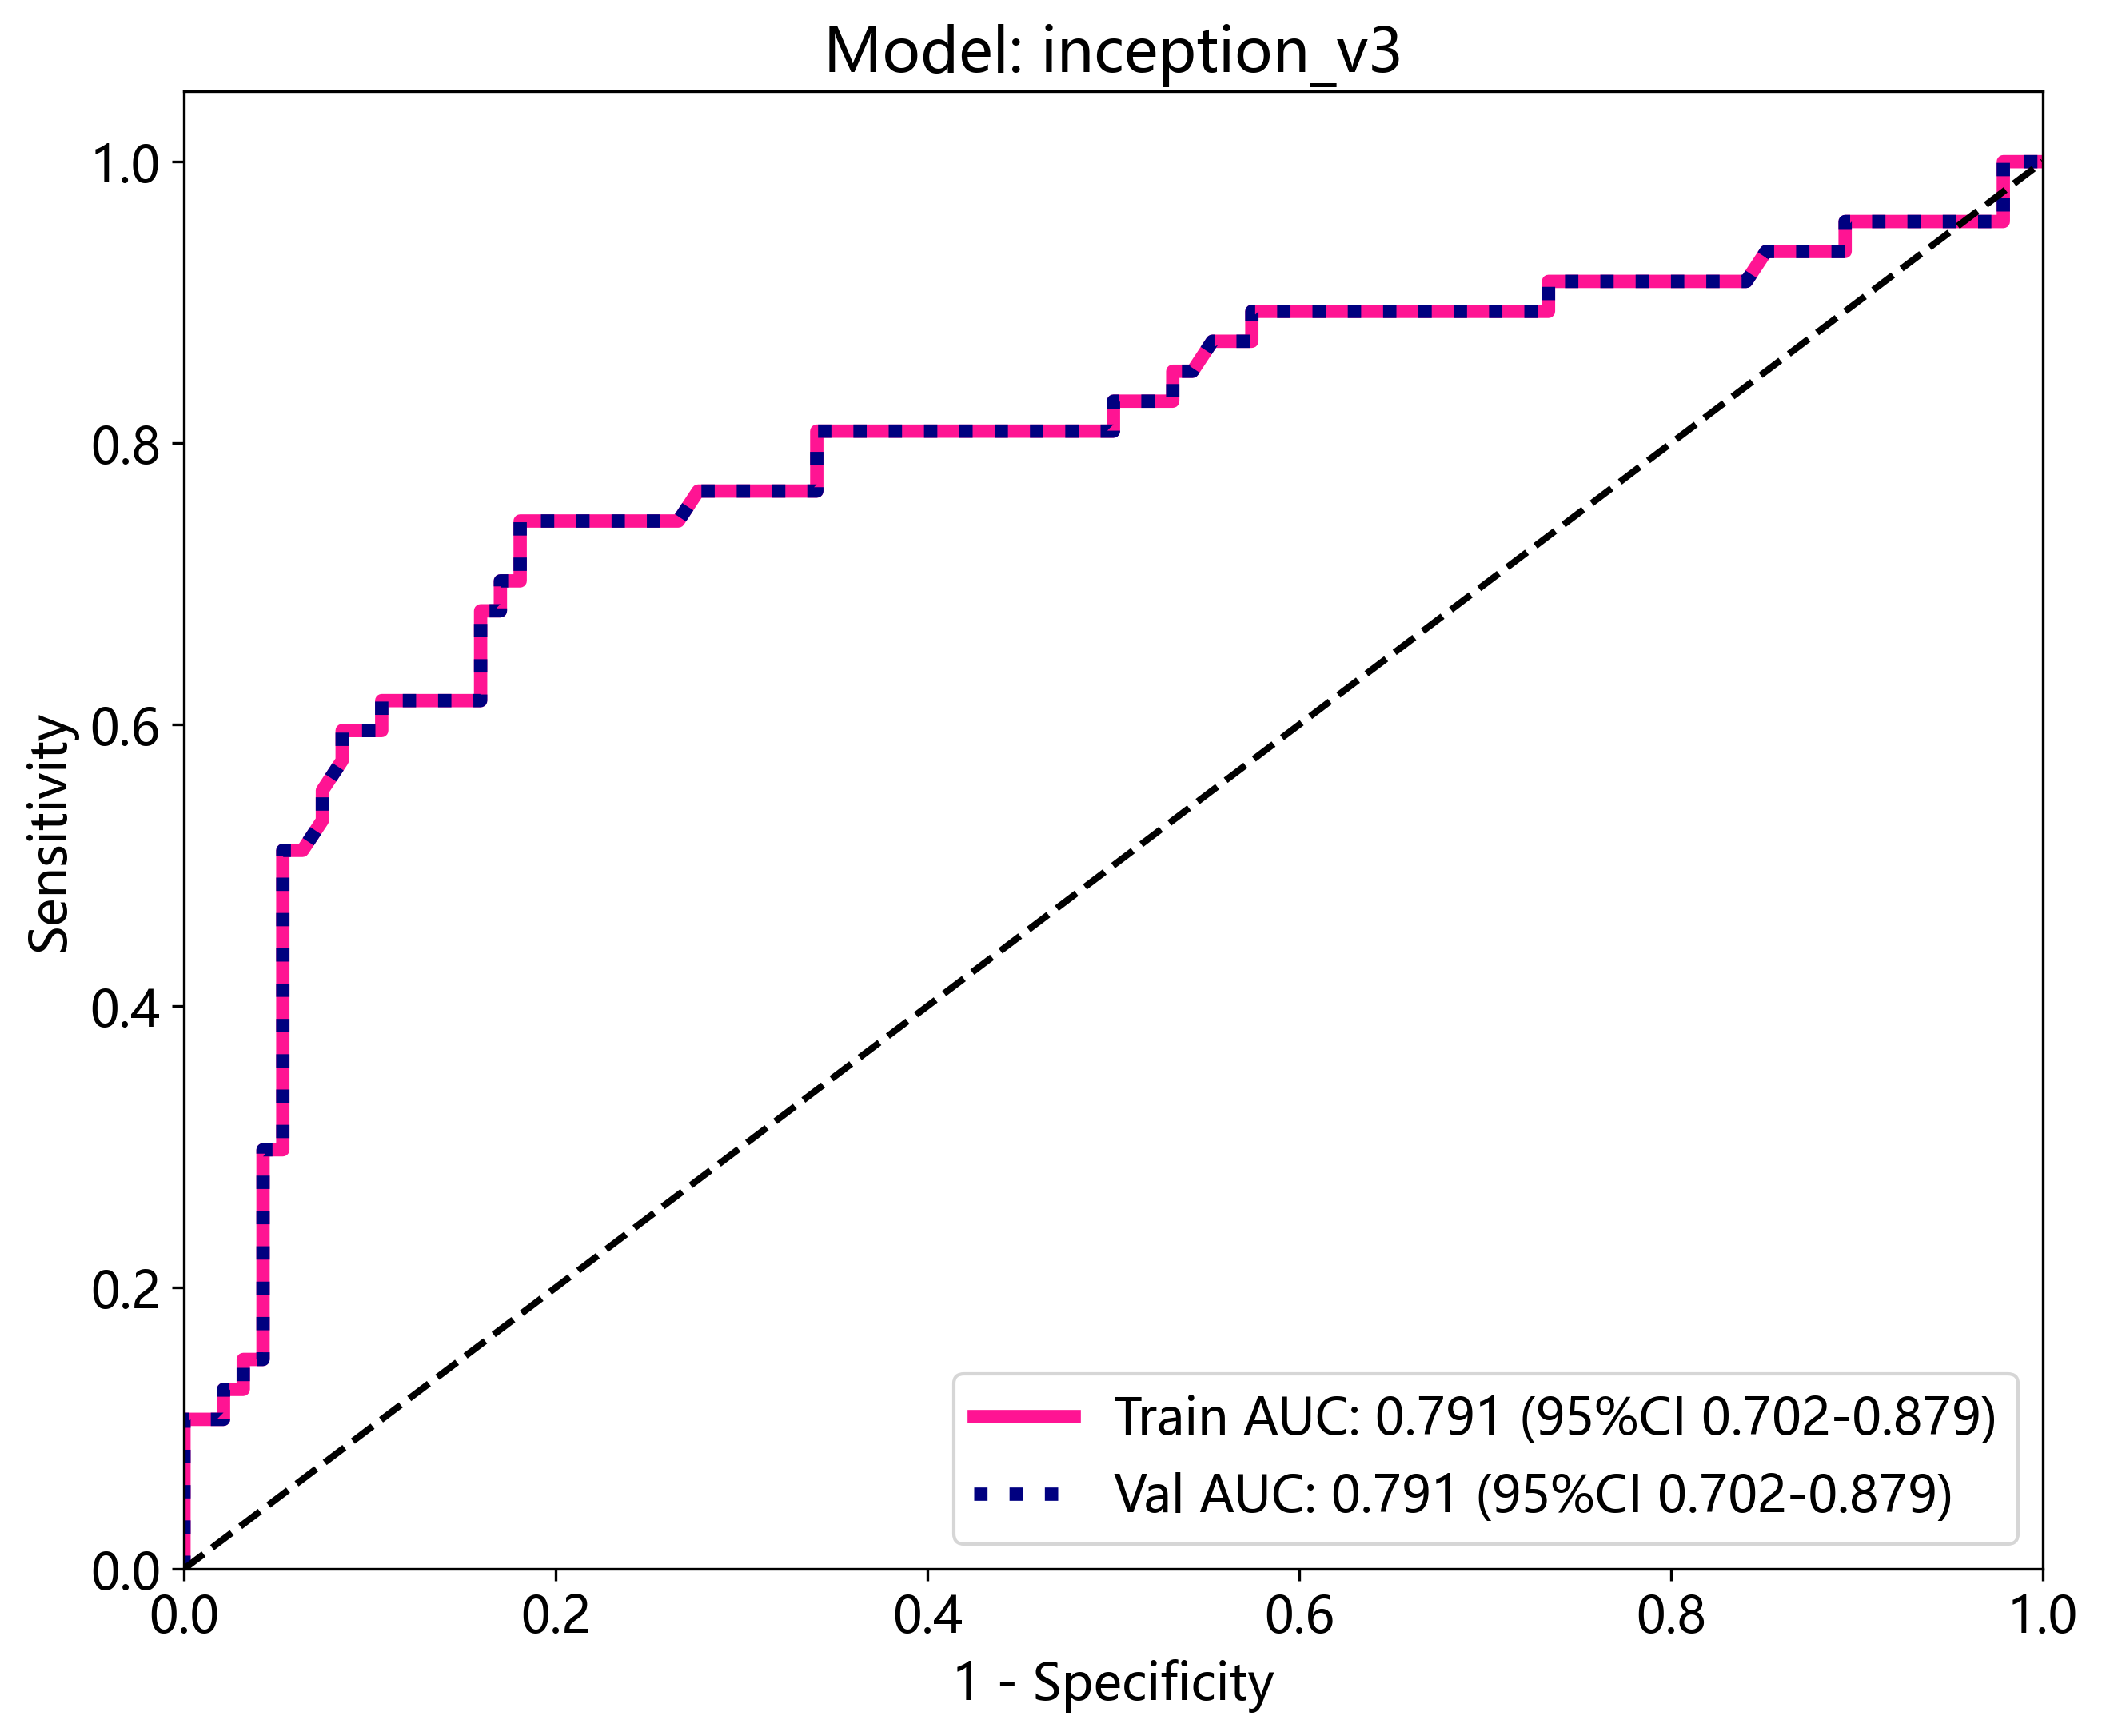

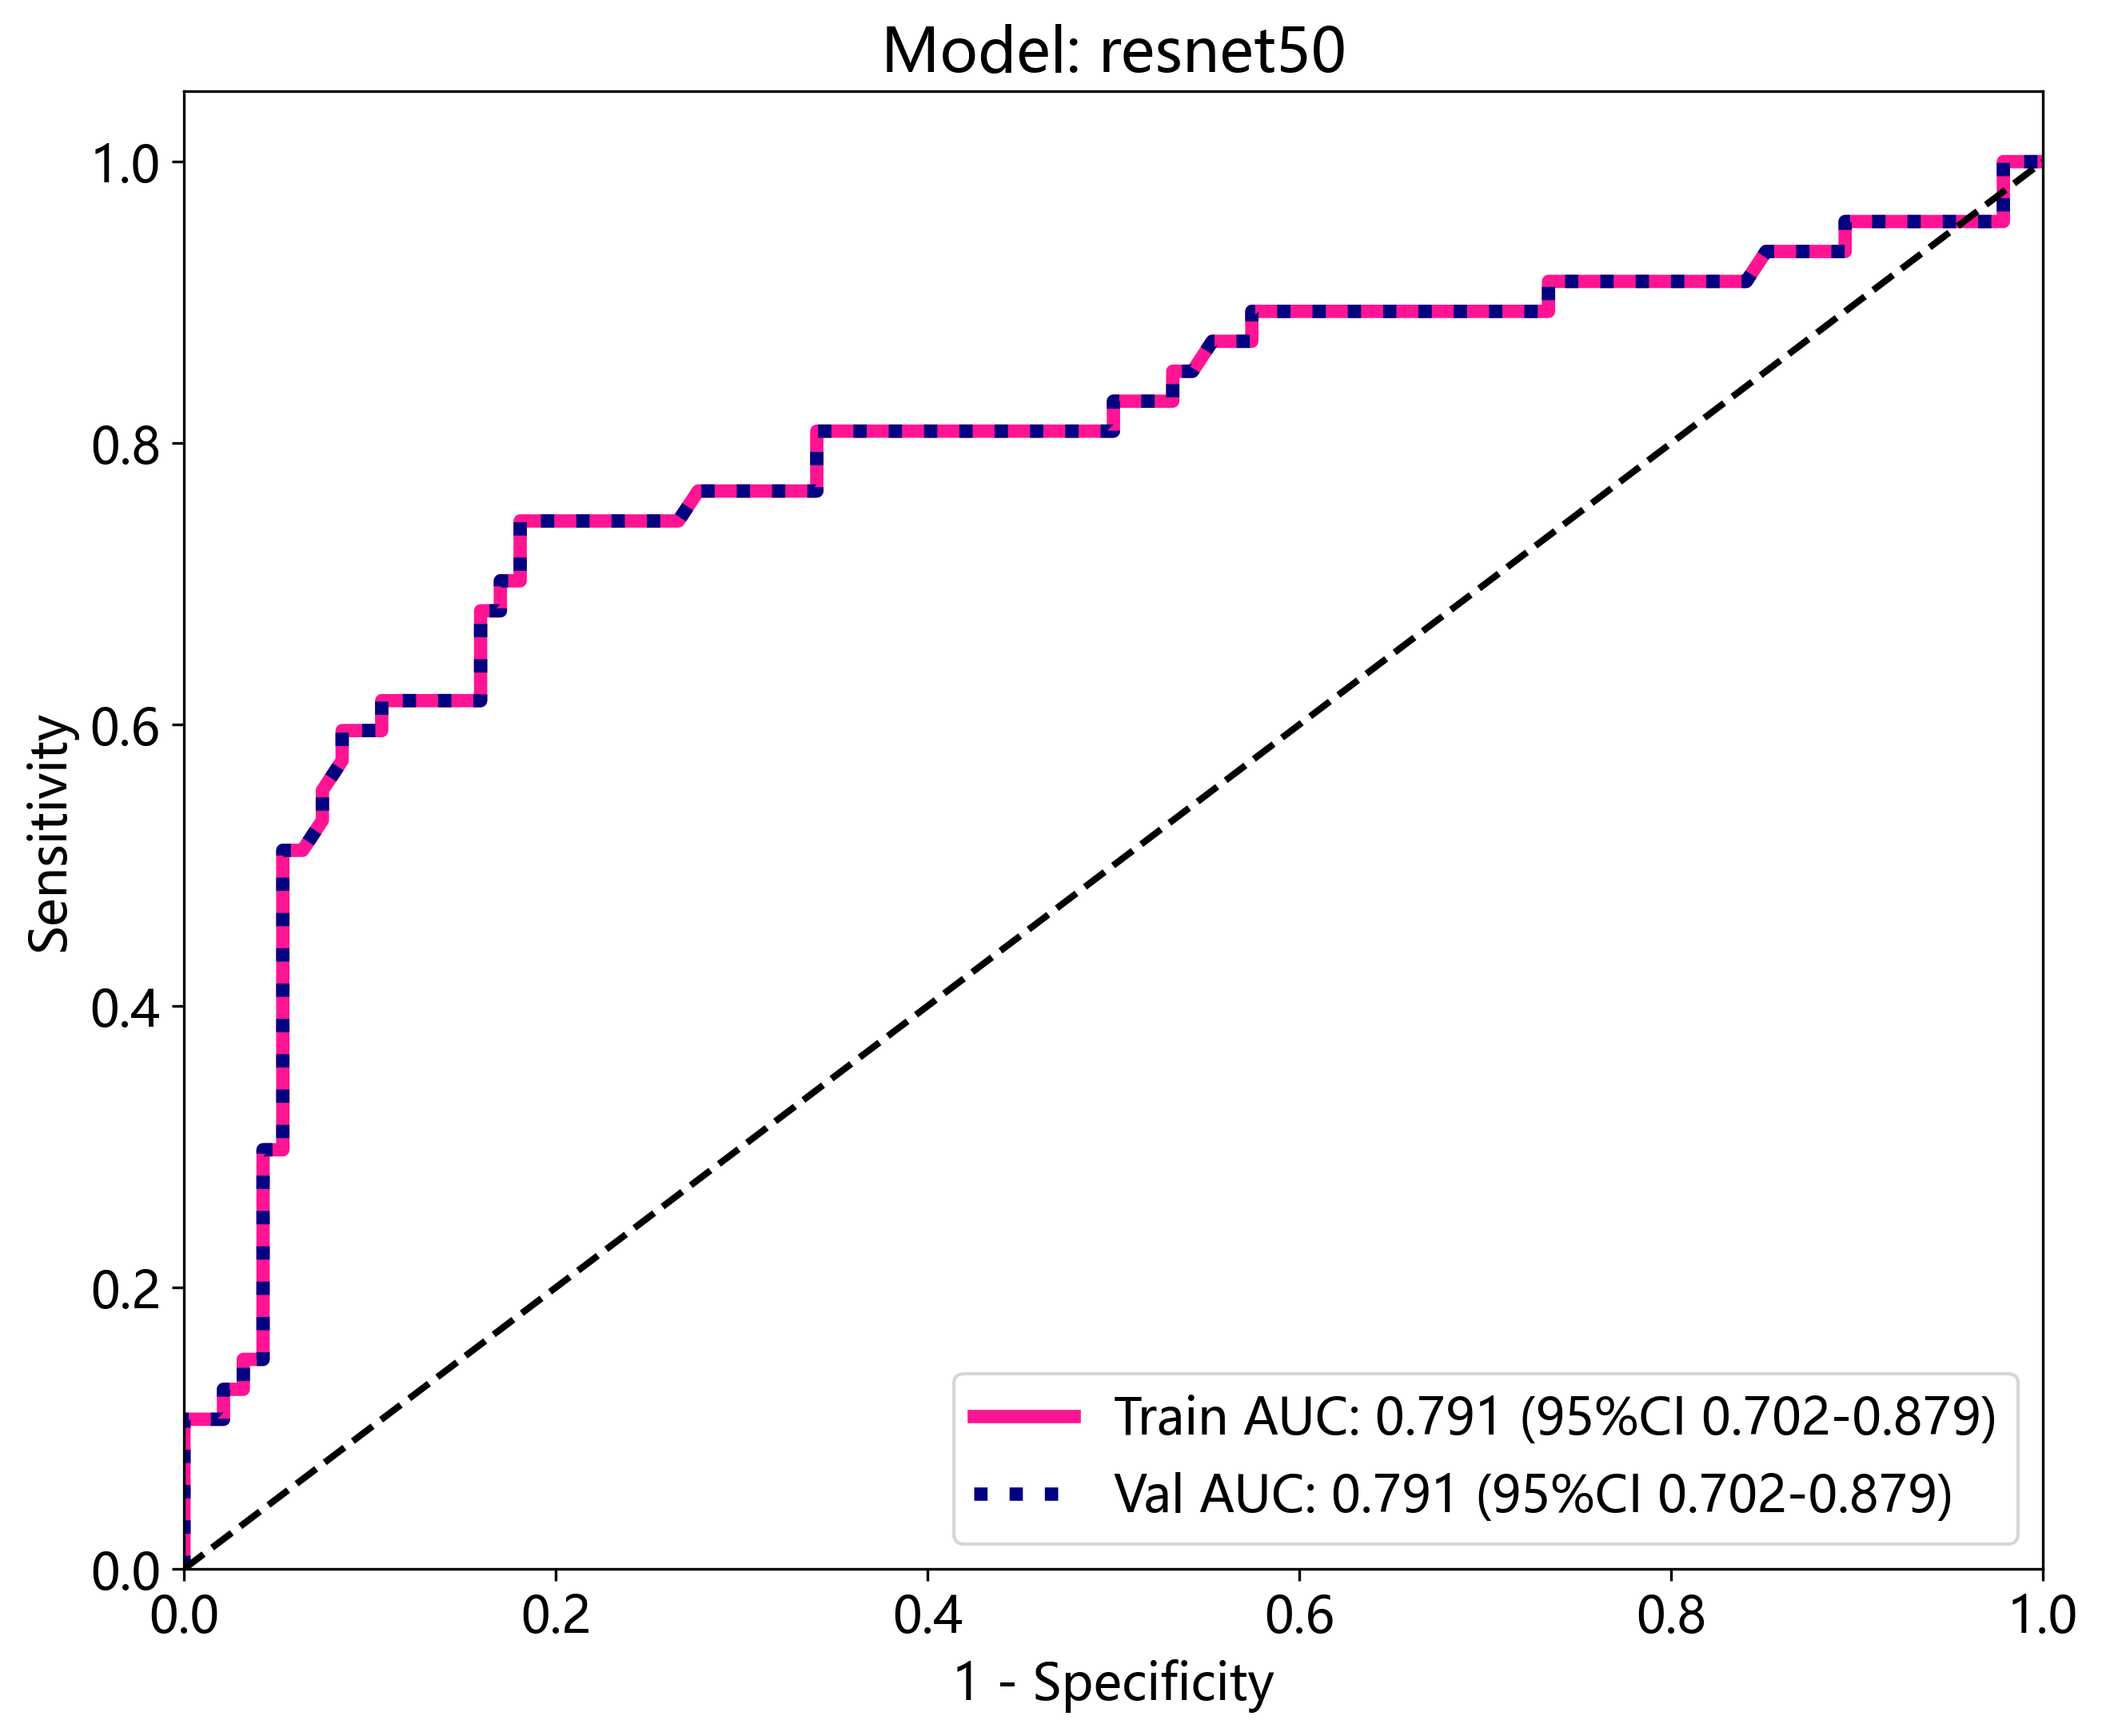

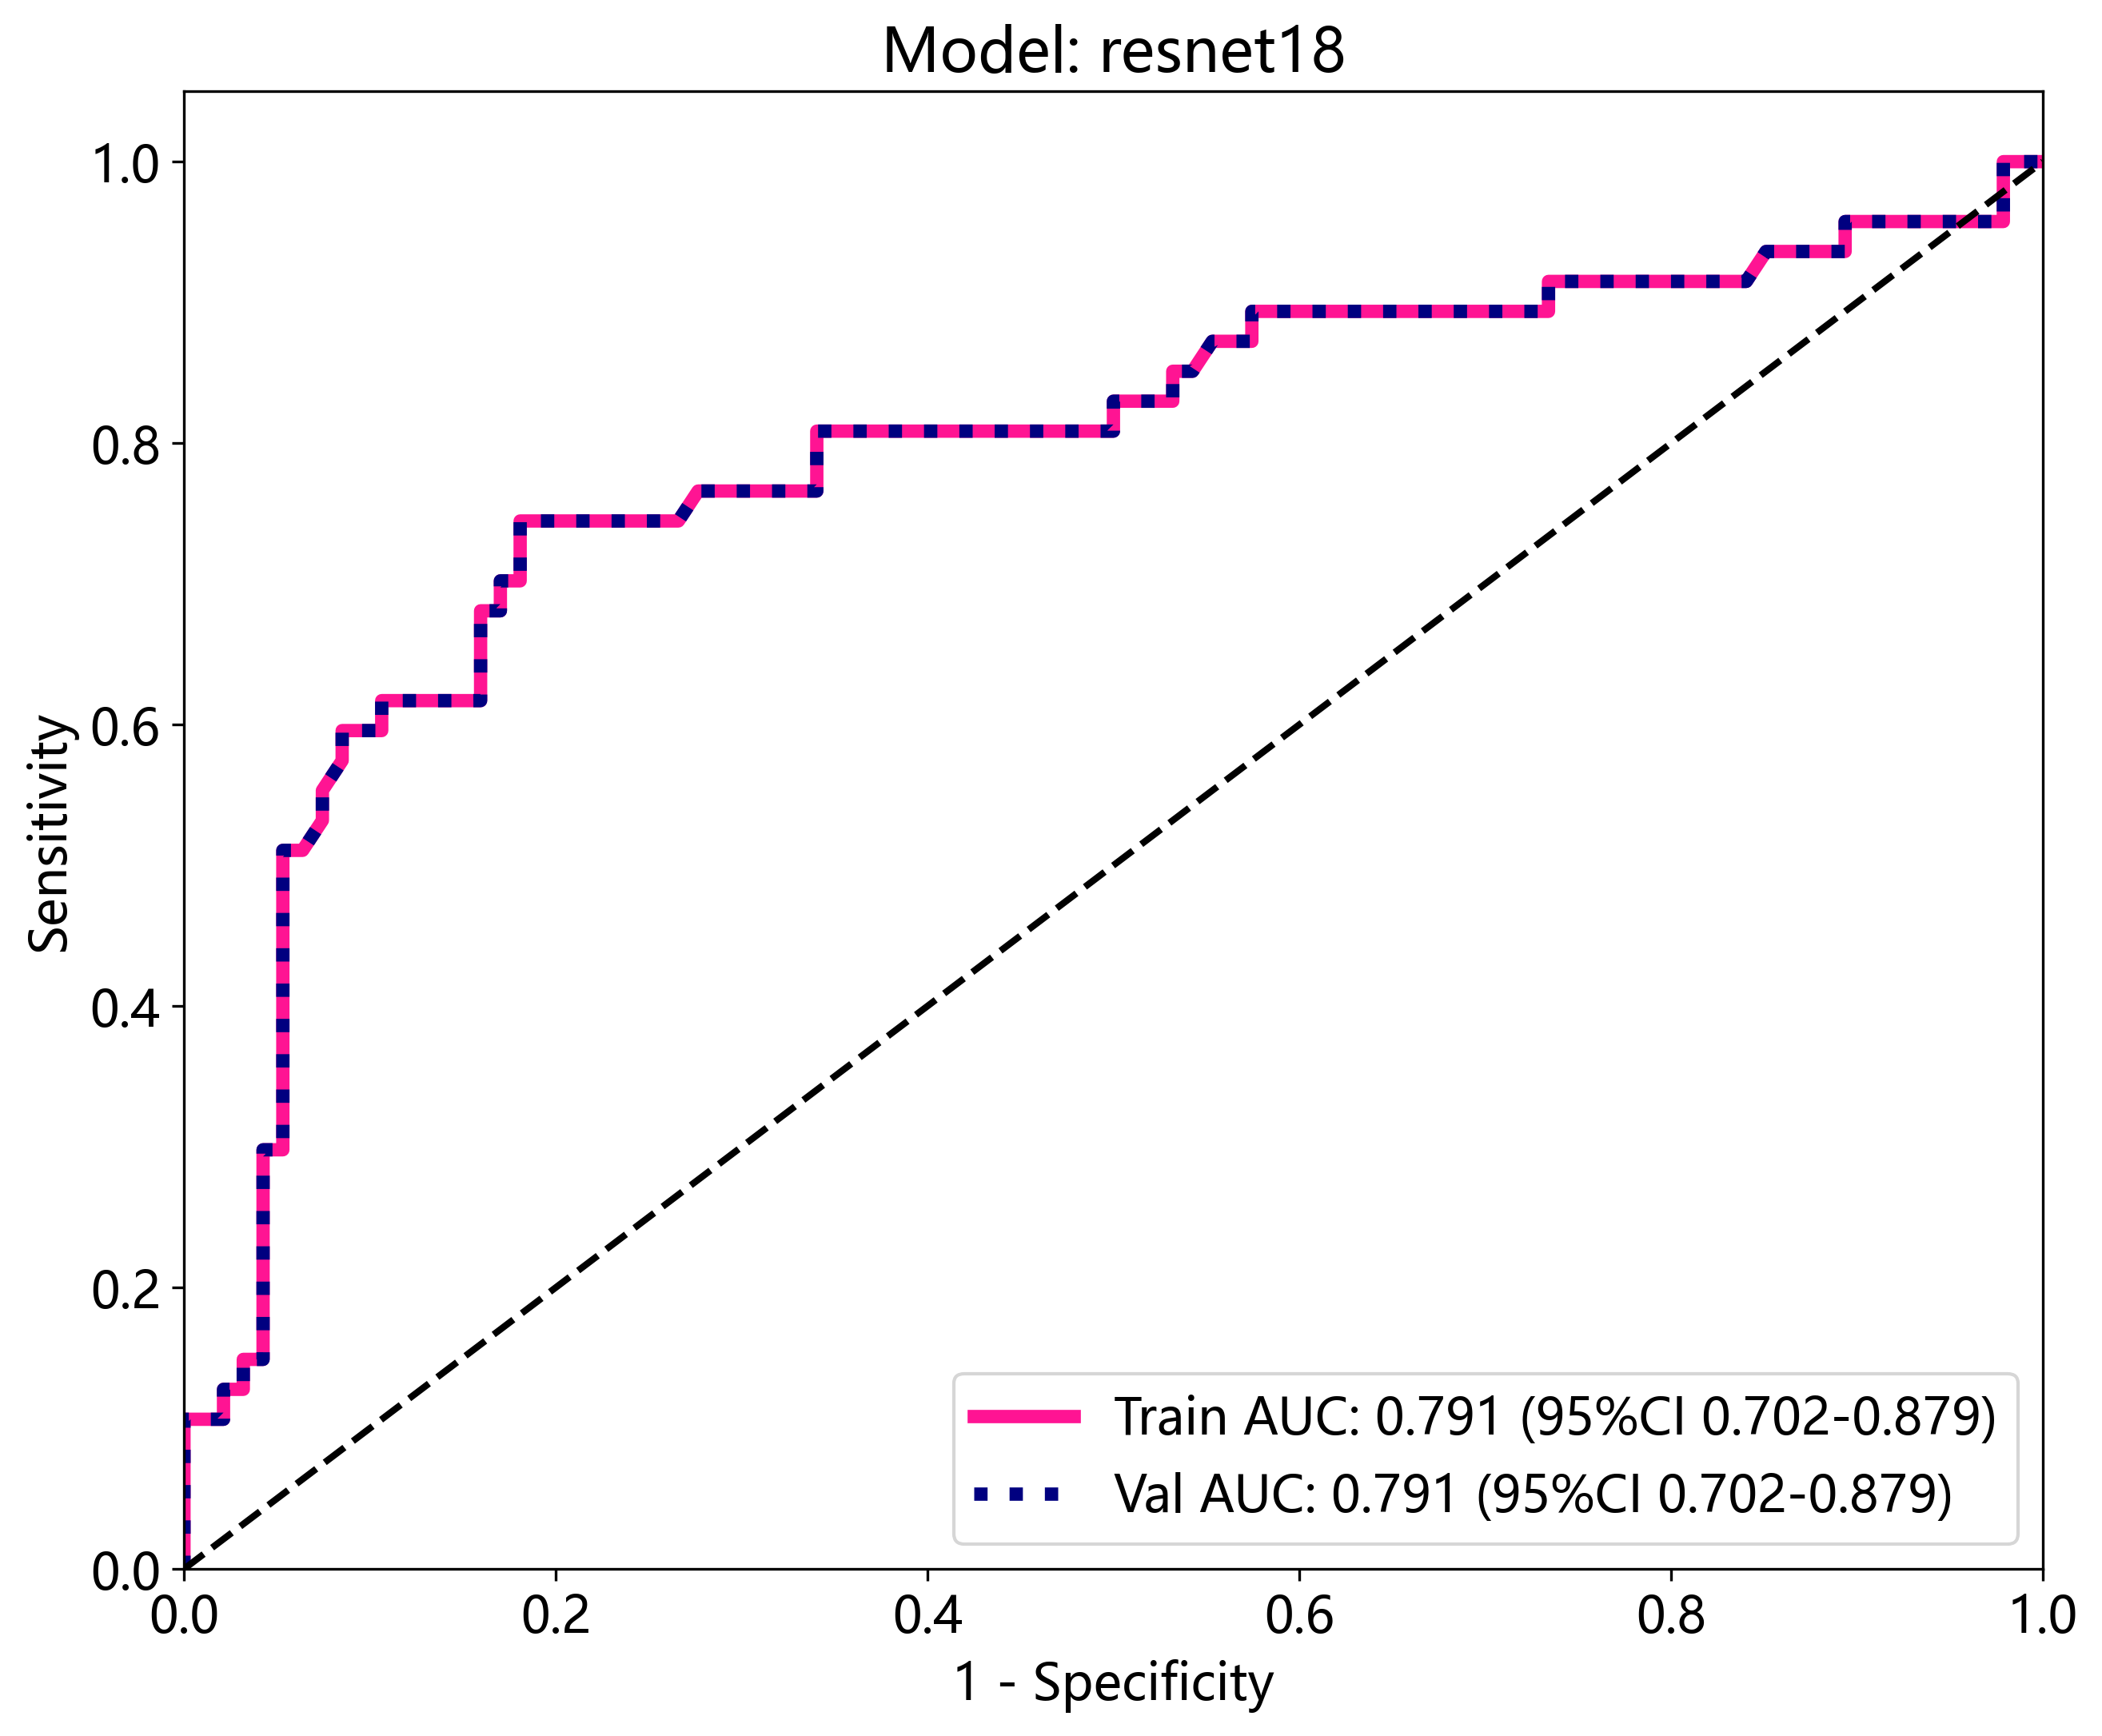

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,densenet121,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Train
1,densenet121,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Test
2,densenet201,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Train
3,densenet201,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Test
4,inception_v3,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Train
5,inception_v3,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Test
6,resnet50,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Train
7,resnet50,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Test
8,resnet18,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Train
9,resnet18,0.794,0.791,0.7018-0.8792,0.745,0.819,0.673,0.865,0.673,0.745,0.707,0.523,Test


In [1]:
import pandas as pd
import numpy  as np
from pixelmed_calc.custom.components import metrics
from pixelmed_calc.custom.components.comp1 import draw_roc
from matplotlib import pyplot as plt

# log_path 修改为Onekey val目录中对应的log文件。
metric_results = []

all_predict_scores = []
all_gts = []
for model in ['densenet121', 'densenet201', 'inception_v3', 'resnet50', 'resnet18']:
    all_pred = []
    all_gt = []
    for subset in ['Train', 'Test']:
        cohort = 'TRAIN' if subset == 'Train' else 'VAL'
        log_path = rf'C:\Users\yxzdxzj\Desktop\function\note2-深度学习分类\resnet50\viz\BST_TRAIN_RESULTS.txt'

        val_log = pd.read_csv(log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
        ul_labels = np.unique(val_log['pred_label'])
#         display(val_log)
        for ul in [1]:
            pred_score = list(map(lambda x: x[0] if x[1] == ul else 1-x[0], np.array(val_log[['pred_score', 'pred_label']])))
            gt = [1 if gt_ == ul else 0 for gt_ in np.array(val_log['gt'])]
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = metrics.analysis_pred_binary(gt, pred_score, use_youden=True)
            ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
            metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, subset])
            all_pred.append(np.array(list(map(lambda x: (1-x[0], x[0]) if x[1] == 1 else (x[0], 1-x[0]), 
                                          np.array(val_log[['pred_score', 'pred_label']])))))
            all_gt.append(gt)
    all_predict_scores.extend(all_pred)
    all_gts.extend(all_gt)
    draw_roc(all_gt, all_pred, labels=['Train', 'Val'], title=f"Model: {model}")
    plt.show()
metrics = pd.DataFrame(metric_results, 
             columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                      'Precision', 'Recall', 'F1', 'Threshold', 'Cohort'])
metrics

In [2]:
log_path = r'C:\Users\yxzdxzj\Desktop\function\note2-深度学习分类\resnet50\viz/BST_{subset}_RESULTS.txt'
train_ = pd.read_csv(log_path.format(subset='TRAIN'), names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
train_['group'] = 'train'
val_ = pd.read_csv(log_path.format(subset='VAL'), names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
val_['group'] = 'test'
data = pd.concat([train_, val_], axis=0)
data

,fname,pred_score,pred_label,gt,group
0,ISIC_0031084.jpg,0.621,2,2,train
1,ISIC_0000030_downsampled.jpg,0.602,2,0,train
2,ISIC_0000008.jpg,0.496,2,0,train
3,ISIC_0000032_downsampled.jpg,0.763,2,2,train
4,ISIC_0000024_downsampled.png,1.000,1,1,train
...,...,...,...,...,...
31,ISIC_0000010.jpg,0.577,2,2,test
32,ISIC_0000018_downsampled.jpg,0.564,2,2,test
33,ISIC_0000003.png,0.857,1,1,test
34,ISIC_0000007.jpg,1.000,2,0,test


In [3]:
predict = []

for idx, row in data.iterrows():
    predict.append([row['fname'].replace('.png', '.gz'), 
                    row['pred_score'] if row['pred_label'] == 0 else 1 - row['pred_score'],
                    row['pred_score'] if row['pred_label'] == 1 else 1 - row['pred_score'],
                    row['group']])
predict = pd.DataFrame(predict, columns=['ID', 'label-0', 'label-1', 'group'])
predict[predict['group'] == 'train'][['ID', 'label-0', 'label-1']].to_csv('DTL_train.csv', index=False)
predict[predict['group'] == 'test'][['ID', 'label-0', 'label-1']].to_csv('DTL_test.csv', index=False)
predict

,ID,label-0,label-1,group
0,ISIC_0031084.jpg,0.379,0.379,train
1,ISIC_0000030_downsampled.jpg,0.398,0.398,train
2,ISIC_0000008.jpg,0.504,0.504,train
3,ISIC_0000032_downsampled.jpg,0.237,0.237,train
4,ISIC_0000024_downsampled.gz,0.000,1.000,train
...,...,...,...,...
172,ISIC_0000010.jpg,0.423,0.423,test
173,ISIC_0000018_downsampled.jpg,0.436,0.436,test
174,ISIC_0000003.gz,0.143,0.857,test
175,ISIC_0000007.jpg,0.000,0.000,test


In [4]:
predict['group'].value_counts()

train    141
test      36
Name: group, dtype: int64